<a href="https://colab.research.google.com/github/OpenITI/acdc_results/blob/main/eval/aocp_ms_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AOCP Manuscript HTR Evaluation

This notebook summarizes our evaluations of OCR accuracy in the Arabic-script OCR Catalyst Project, part of the Open Islamicate Texts Initiative. You can modify the code to look at different aspects of the data.

## Setup Code

First we load some packages.

In [59]:
suppressPackageStartupMessages({
  library(tidyverse)
})

Then we load the output of our evaluation runs and some metadata.

In [60]:
enames <- read.csv("https://raw.githubusercontent.com/OpenITI/acdc_results/main/meta/enames.csv", header=TRUE)
book.meta <- read.csv("https://raw.githubusercontent.com/OpenITI/acdc_results/main/meta/htr.csv", header=TRUE)
stats <- read.csv("https://raw.githubusercontent.com/OpenITI/acdc_results/main/eval/stats.csv", header=TRUE) %>%
  filter(!is.na(characters)) %>% mutate(car=1-errors/characters, arabic_car=1-arabic_missed/arabic_count)

Here are the average character accuracy rate (CAR) numbers for each evaluation run. The `test` records the test set. Since ACDC and supervised training use the `acdc_mss` books, those numbers will be relatively high. For evaluation, we focus on the `aocp_ms_eval` test set.

In [61]:
stats %>% filter(!str_starts(book, "druze")) %>%
  group_by(model, test) %>% summarize(car=mean(car), .groups="drop") %>% arrange(test, -car)

model,test,car
<chr>,<chr>,<dbl>
sup5-nall-ft_best,acdc_mss,0.9508909
pdf-gen2-print-n7m5-supunion-ft_best,acdc_mss,0.8700365
pdf-print-n7m5-level-sup5-ft_best,acdc_mss,0.8270370
pdf-gen2-print-n7m5-union-ft_best,acdc_mss,0.7946059
pdf-gen1-print-n7m5-nall-ft_best,acdc_mss,0.7781898
pdf-gen1-print-n7m5-nall-sc_best,acdc_mss,0.7631075
pdf-print-n7m5-nall-ft_best,acdc_mss,0.7404780
pdf-print-n7m5-n1000-ft_best,acdc_mss,0.7281386
pdf-print-n7m5-nall-sc_best,acdc_mss,0.7103605


We assign short names to each model in our evaluation for easier display.

In [62]:
aocp.test <- stats %>% filter(test == "aocp_ms_eval") %>%
  filter(model %in% c("print_transcription_NEW", "pdf-print-n7m5-nall-ft_best", "pdf-gen1-print-n7m5-nall-ft_best", "pdf-gen2-print-n7m5-union-ft_best",
                      "pdf-gen2-print-n7m5-supunion-ft_best", "sup5-nall-ft_best")) %>%
  mutate(model=recode_factor(model, `print_transcription_NEW`="print",
                              `sup5-nall-ft_best`="supervised",
                              `pdf-print-n7m5-nall-ft_best`="acdc1", `pdf-gen1-print-n7m5-nall-ft_best`="acdc2",
                              `pdf-gen2-print-n7m5-union-ft_best`="acdc3",
                              `pdf-gen2-print-n7m5-supunion-ft_best`="supervised+acdc3"))

In [63]:
compare.models <- function(test, model1, model2) {
  filter(test, model == model1) %>% select(book, baseline=arabic_car) %>%
    inner_join(filter(test, model == model2) %>% select(book, contender=arabic_car), by="book")
}

Now map eScriptorium URLs to book names and metadata.

In [64]:
meta <- book.meta %>% mutate(epk=as.integer(str_match(eScriptorium, "/document/(\\d+)")[,2])) %>%
  inner_join(enames, by="epk") %>%
  mutate(raw.lang=language, language=as.factor(if_else(str_detect(raw.lang, ",|and"), "mixed", raw.lang))) %>%
  mutate(symbol=str_sub(language, 1, 1))

## Summary Evaluation

We summarize the character accuracy rate for each model, giving the mean, median, minimum, and maximum character error rate over all books in the AOCP test set.

In [65]:
aocp.test %>% group_by(model) %>% summarize(mean=mean(car), median=median(car), min=min(car), max=max(car))

model,mean,median,min,max
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
print,0.6048141,0.6136490,0.011142061,0.8379032
supervised,0.7637194,0.7851822,0.110027855,0.9306452
acdc1,0.7670792,0.8016009,0.054317549,0.9645161
acdc2,0.7882757,0.8213013,0.009749304,0.9552419
acdc3,0.8010340,0.8286720,0.036211699,0.9520161
supervised+acdc3,0.8197875,0.8471593,0.045016077,0.9677419


The mean and median diverge a bit from each other, so let's look at the full distribution.

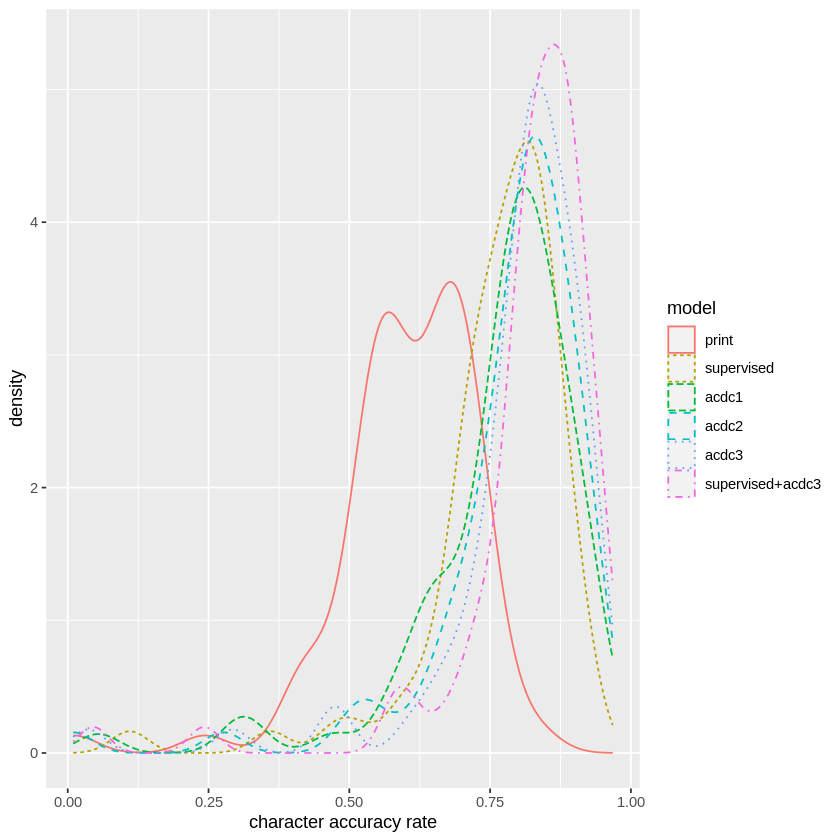

In [66]:
ggplot(aocp.test, aes(car, color=model, linetype=model)) + geom_density() + labs(x="character accuracy rate")

Although all models struggle with a couple of texts getting accuracies below 30%, we see that unsupervised ACDC training or ACDC combined with some supervised training, gets significantly higher accuracy.

Now we drill down into these results by language. Here is the language distribution in the AOCP test set.

In [67]:
meta %>% group_by(raw.lang, language) %>% count() %>% arrange(-n)

raw.lang,language,n
<chr>,<fct>,<int>
Arabic,Arabic,58
Ottoman Turkish,Ottoman Turkish,17
Persian,Persian,15
Malay,Malay,4
Arabic and Persian,mixed,1
"Arabic, Ottoman Turkish",mixed,1
"Arabic, Persian",mixed,1
"Arabic, Persian, and Ottoman Turkish",mixed,1
"Malay, Arabic",mixed,1


Here we plot each book using a letter code for its language: `A` for Arabic, `m` for mixed, and so on. Plotting the baseline model trained on printed Arabic-script on the x-axis against the combined `supervised+acdc3` model on the y-axis, we can see that all points are above a 45 degree line and therefore achieved improved accuracy.

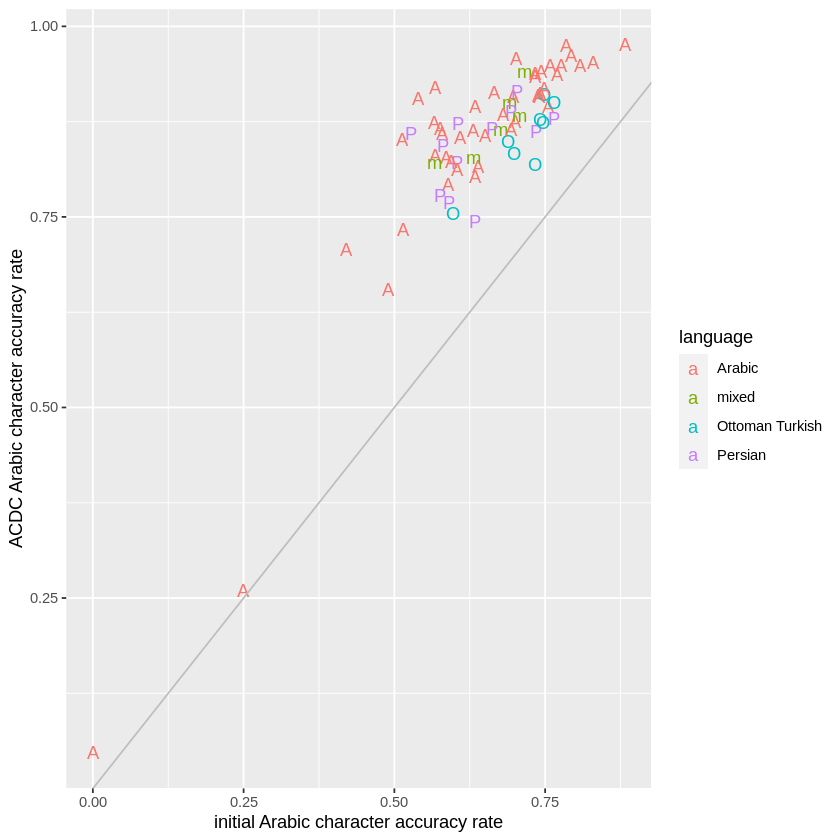

In [68]:
aocp.test %>%# filter(!str_starts(book, "vieac")) %>%
  compare.models("print", "supervised+acdc3") %>%
  left_join(meta, by="book") %>% filter(!is.na(symbol)) %>%
  ggplot(aes(baseline, contender, color=language, label=symbol)) + geom_text() + geom_abline(slope=1, color="grey") +
  labs(x="initial Arabic character accuracy rate", y="ACDC Arabic character accuracy rate")

We also see two Arabic documents with accuracies below 30%. We now zoom in on the rest of the documents and compare supervised training alone to supervised training plus ACDC. Again, all books showed improvement. In absolute terms, many more books are above the horizontal 90% line than there are to the right of the vertical 90% line.

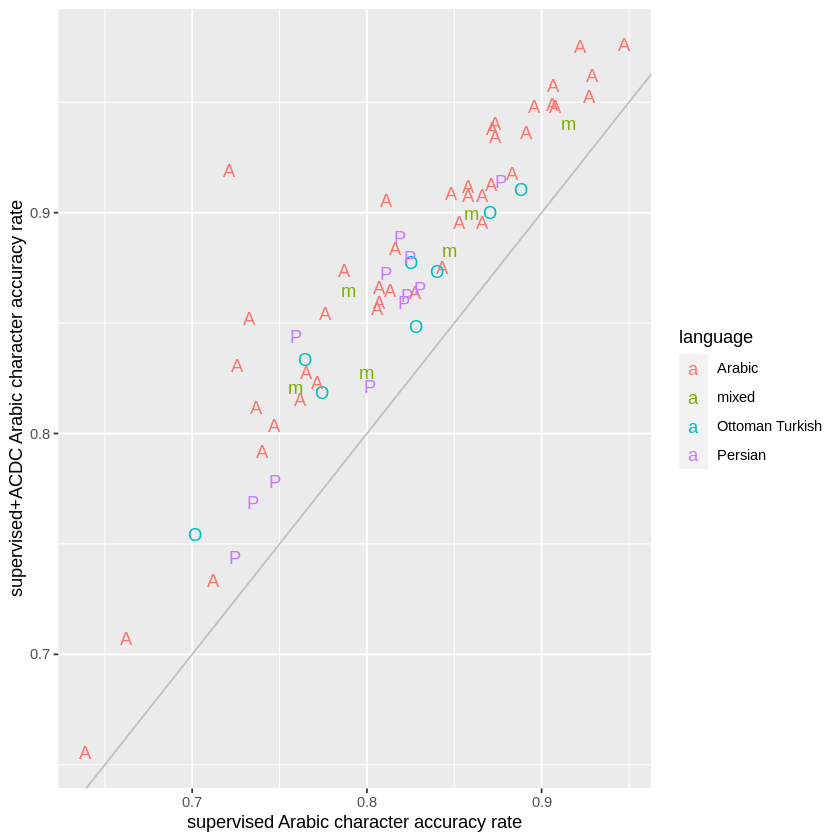

In [69]:
aocp.test %>% filter(!str_starts(book, "vieac")) %>%
  compare.models("supervised", "supervised+acdc3") %>%
  left_join(meta, by="book") %>% filter(!is.na(symbol)) %>%
  ggplot(aes(baseline, contender, color=language, label=symbol)) + geom_text() + geom_abline(slope=1, color="grey") +
  labs(x="supervised Arabic character accuracy rate", y="supervised+ACDC Arabic character accuracy rate")

Finally, we show the accuracy of all five models on each book in the AOCP test set. You can modify the final `arrange` statement to resort the data.

In [77]:
options(repr.matrix.max.rows=600)
aocp.test %>% select(book, model, arabic_car) %>%
  left_join(select(meta, book, date, language, script=primary_script_style), by="book") %>%
  arrange(book, model) %>%
  pivot_wider(names_from=model, values_from=arabic_car) %>%
  arrange(-`supervised+acdc3`)

book,date,language,script,print,supervised,acdc1,acdc2,acdc3,supervised+acdc3
<chr>,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
bsb_cod_arab_463,1750,Arabic,Naskh,0.8821237,0.94739406,0.97272284,0.96151973,0.96200682,0.97613249
leipzig_vollers_393,1700,Arabic,Naskh,0.7853577,0.92179700,0.94675541,0.97004992,0.96672213,0.97504160
sbzb_petermann_ii_446,1300,Arabic,Naskh,0.7925983,0.92906708,0.93446415,0.92135698,0.94217425,0.96222051
national_library_of_israel_ms_ar_497,1650,Arabic,Naskh,0.7022508,0.90675241,0.92861736,0.94662379,0.92475884,0.95755627
tubingen_ma_vi_83,1750,Arabic,Naskh,0.8288863,0.92691415,0.92749420,0.92575406,0.94315545,0.95246479
leipzig_vollers_226,1620,Arabic,Naskh,0.8077193,0.90596491,0.92842105,0.92842105,0.93614035,0.94902235
leipzig_vollers_686,1471,Arabic,Naskh,0.7586926,0.89568846,0.93045897,0.94158554,0.93463143,0.94829932
sbzb_landberg_232,1531,Arabic,Naskh,0.7761628,0.90755814,0.93779070,0.92732558,0.94941860,0.94825581
mcgill_manuscript_40,1824,Arabic,Naskh-Nasta'liq,0.7427844,0.87351443,0.91426146,0.90577250,0.92359932,0.94057725
